### Load data and generate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import ks_2samp
%matplotlib inline
plt.style.use('ggplot')

## Lab ranges

'Normal' ranges for lab values:

Lab Value	|  Lower limit	|  Upper Limit	|  Units
--- | --- | --- | ---
Albumin | 3.5 | 5.5 | g/dL
Bicarbonate	| 22	| 32	| mEq/L
BUN	| 6	| 20 | mEq/L
Calcium	| 8.4	| 10.3	| mg/dL
Chloride	| 96	| 108	| mEq/L
Creatinine	| 0.4	| 1.1	| mEq/L
Glucose | 70 | 100 | mg/dL
Hemoglobin	| 11.2	 | 15.7	| g/dL
Lactate	| 0.5	| 2	| mmol/L
Magnesium	| 1.6	| 2.6	| mg/dL
Phosphate	| 2.7	| 4.5	| mg/dL
Platelet count	| 150	| 400	| K/uL
Potassium	| 3.3	| 5.1	| mEq/L
Sodium	| 133	| 145	| mEq/L
Free Calcium | 1.1 | 1.35 | mmol/L

In [2]:
# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'ALBUMIN':[3.5, 5.5], 
              'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'GLUCOSE':[70.0, 100.0],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145],
              'FREECALCIUM': [1.1, 1.35],
              'WBC': [3.5, 10.5]
             }
labs = dict((i, 0) for i in lab_ranges.keys())

mimic = pd.read_csv("all_data_minmax.csv", index_col=0)
#mimic = pd.read_pickle("./all_data_minmax.pkl")
lab_columns = mimic.columns.values[1:]

In [ ]:
#data.sort_values(by=['los'])
data[['subject_id', 'sodium_min', 'sodium_max']]

In [ ]:
data.columns

### Plot figures
##### Missing patients figure

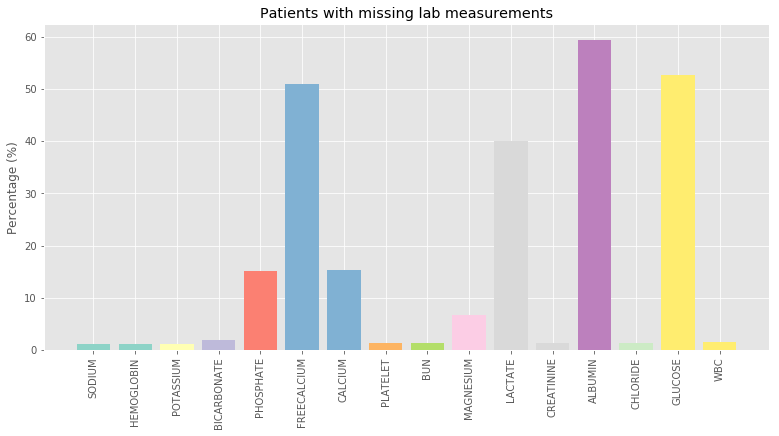

In [3]:
missing = dict((i, 0) for i in lab_ranges.keys())

for labname, vrange in lab_ranges.items():
    colname = labname.lower() + "_max"
    labs[labname] = mimic.loc[:, ['subject_id', colname]]

for labname, val in labs.items():
    colname = labname.lower() + "_max"
    missing[labname] = val[colname].isnull().sum() / float(val['subject_id'].count())
    #missing[labname] = val.dropna().count()/val.count()
    #print len(val['subject_id'].unique())
#print missing

x = np.arange(len(missing.keys()))
color_list = plt.cm.Set3(np.linspace(0, 1, len(missing.keys())))
y = missing.values()
plt.subplots(figsize=(13,6))
plt.bar(x, height=[i*100 for i in y], color=color_list)
plt.xticks(x, missing.keys(), rotation='vertical')
plt.title("Patients with missing lab measurements")
plt.ylabel("Percentage (%)")

data = mimic.copy()

### Segment and plot variables

+ Update 22 March: Set percentaile line y static; adjust x-axis limits; 
+ Update 15 August: Change to min/max figures

## Minimum Value Plots

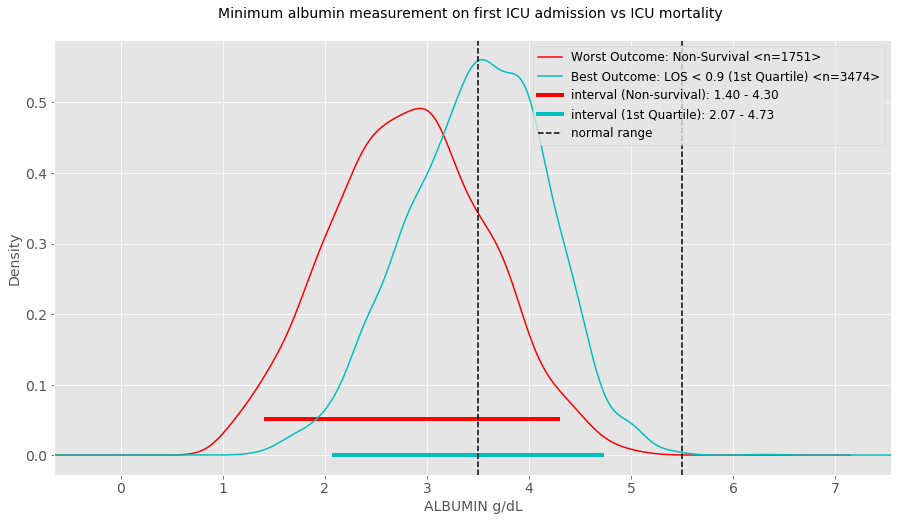

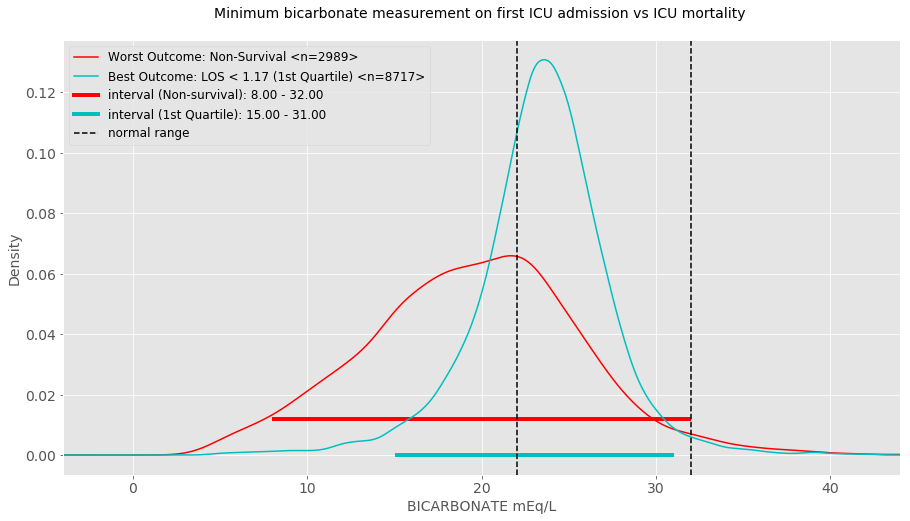

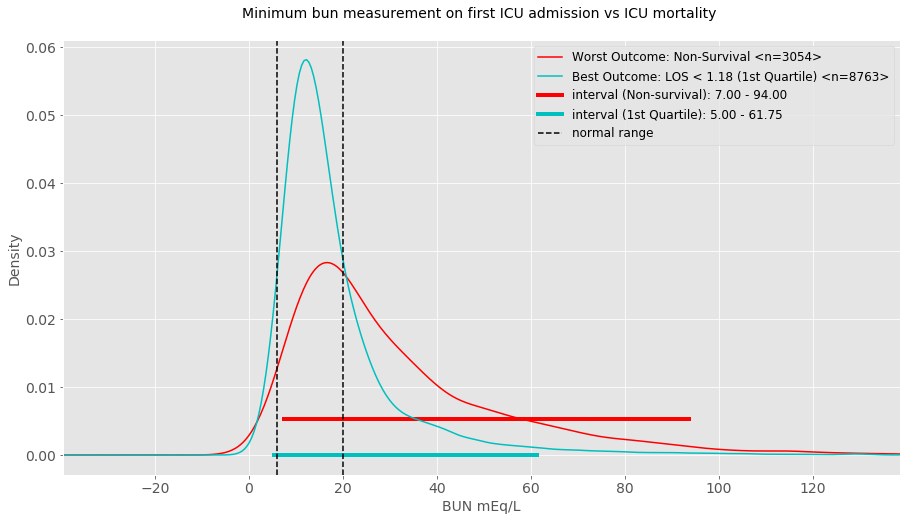

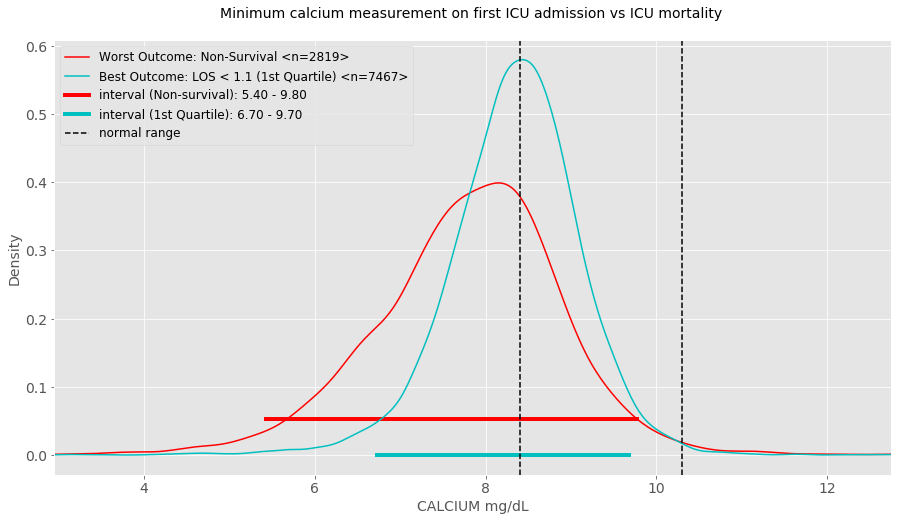

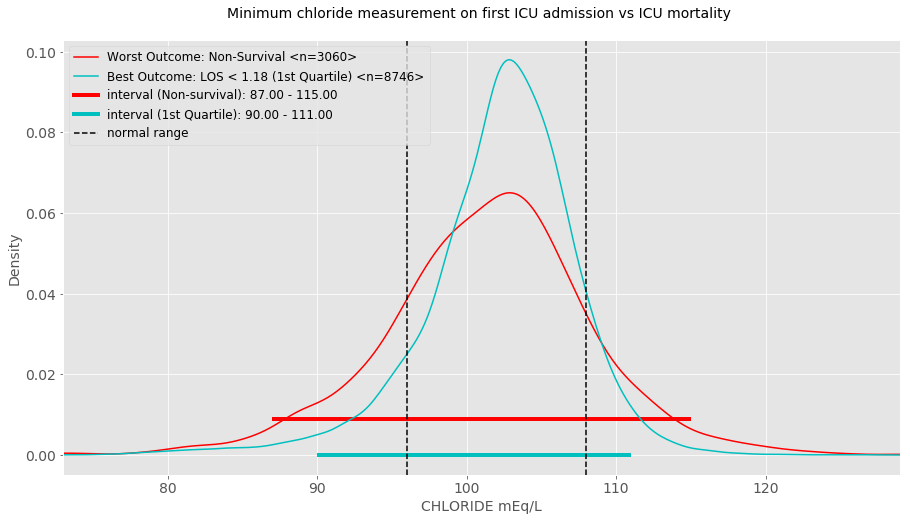

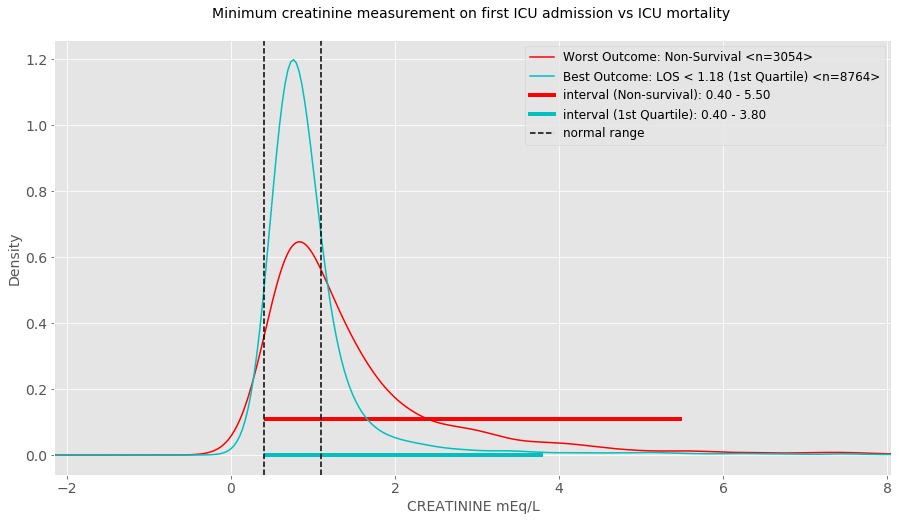

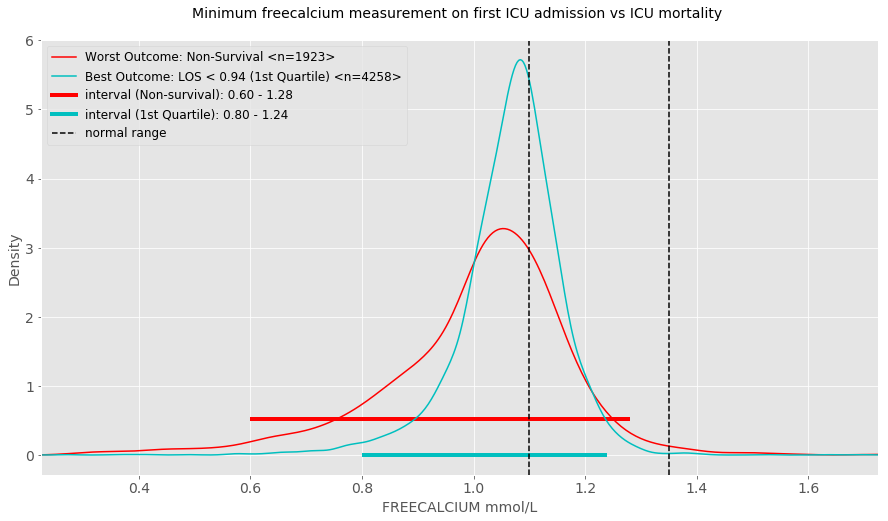

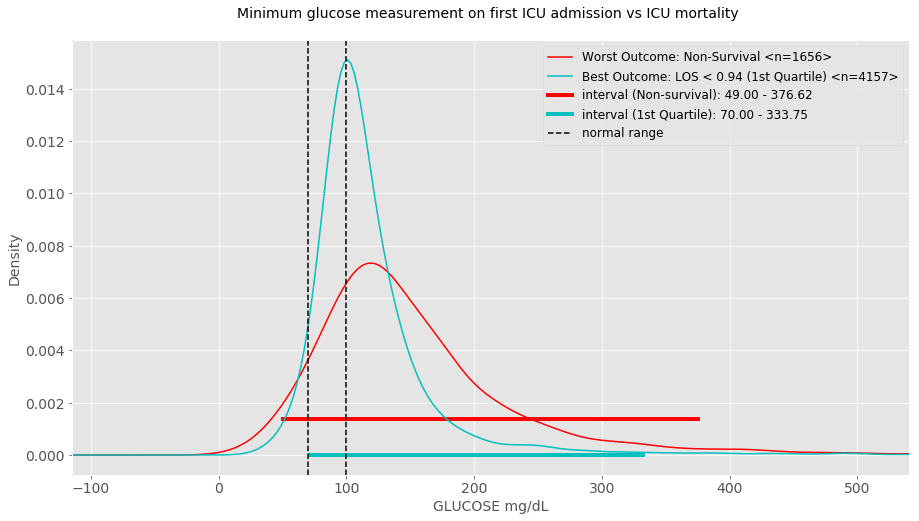

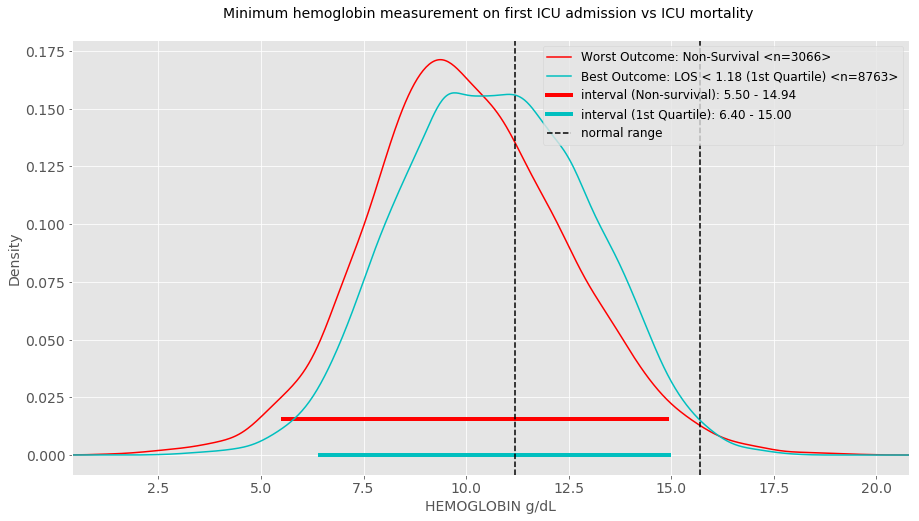

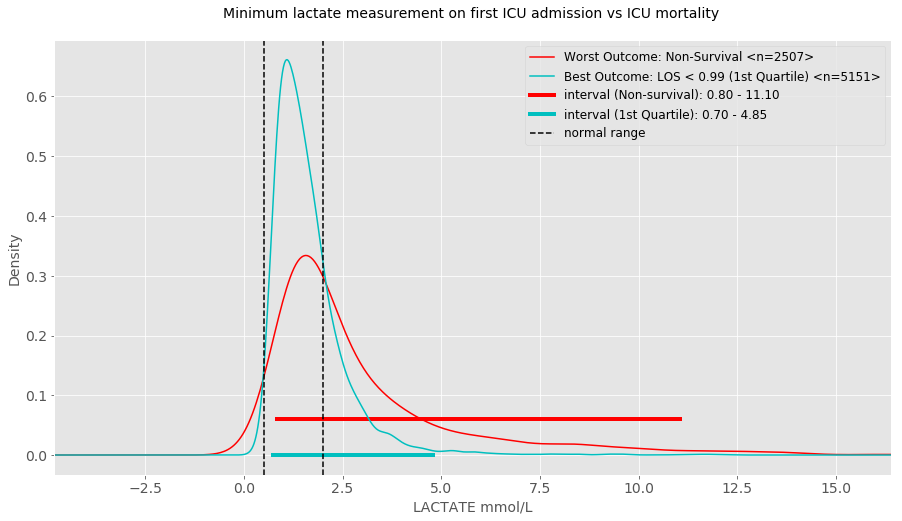

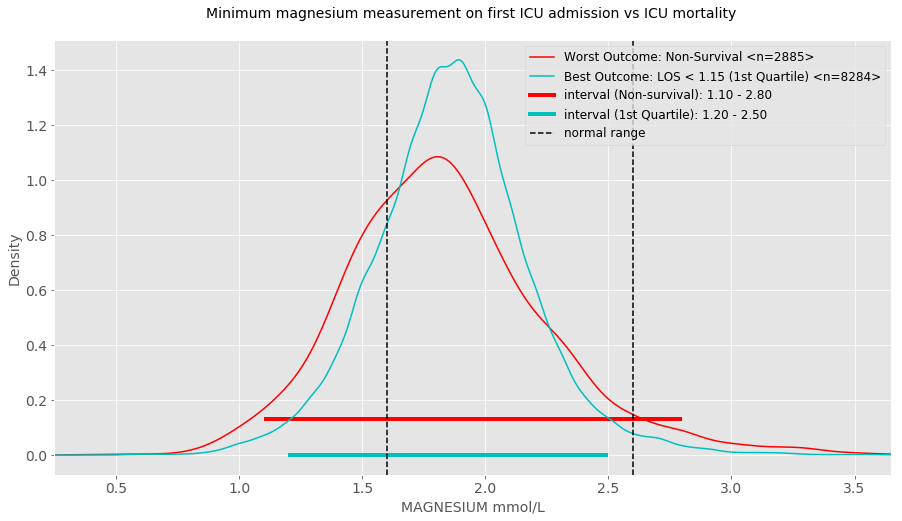

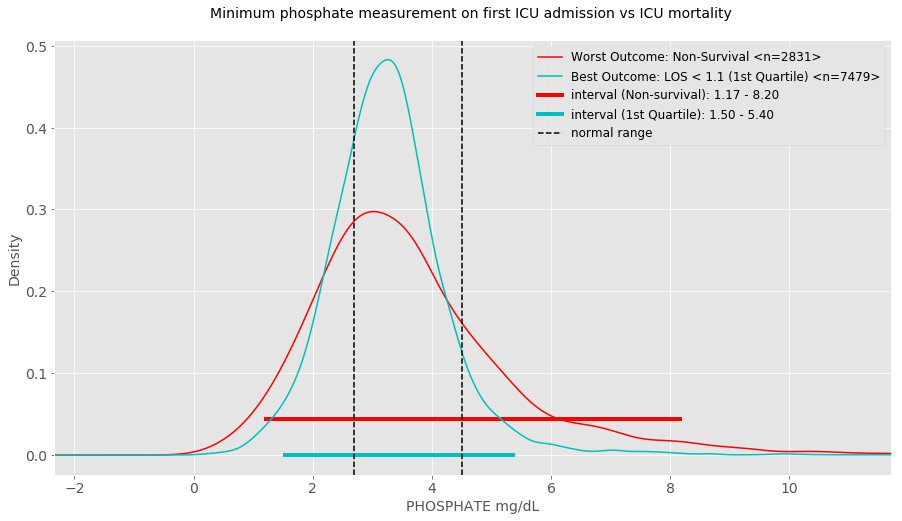

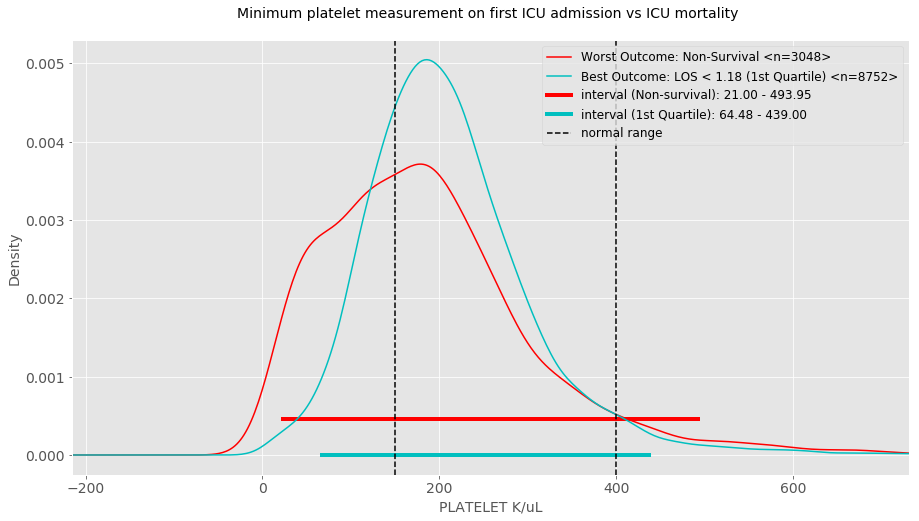

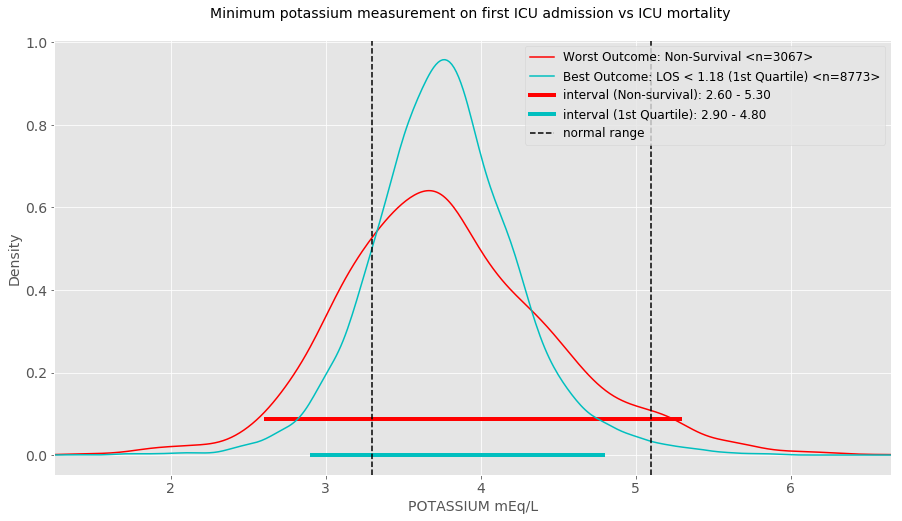

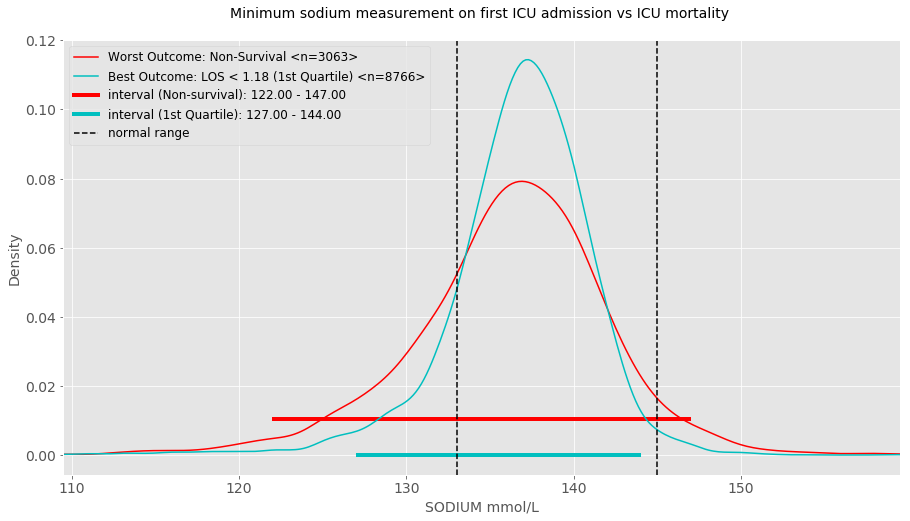

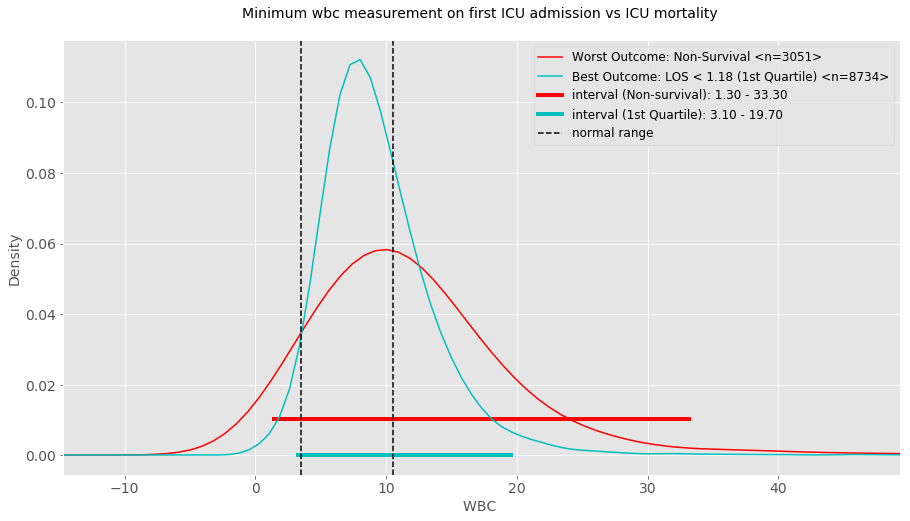

In [4]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

cond_less = data.mort_icu == 0 #& (data.los < LOS_med)

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    
    n_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().count()
    n_less = data[l.lower()+'_min'][cond_less].dropna().count()
    quater = n_less / 4 
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().median()
    med_less = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).median()
    var_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().var()
    var_less = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).var()
    skew_nonsurv = data[l.lower()+'_min'][data.mort_icu==1].dropna().skew()
    skew_less = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).skew() 
    los_quarter = data.sort_values(by=['los'])['los'][cond_less].dropna().head(quater).max().round(2)
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_min'][data.mort_icu==1].dropna(),
                              data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater))

    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    data[l.lower()+'_min'][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Worst Outcome: Non-Survival <n={}>'.format(n_nonsurv), color='r')
    data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].dropna().head(quater).plot.kde(
        alpha=1.0,label='Best Outcome: LOS < {} (1st Quartile) <n={}>'.format(los_quarter, quater), color='c')
    
#     # fake plots for KS test, median, etc
#     plt.plot([], label=' ',color='lightgray')
#     plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
#              color='lightgray')
#     plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Median (LOS < med): {}'.format(format(med_less,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Variance (LOS < med): {}'.format(format(var_less,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Skew (LOS < med): {}'.format(format(skew_less,'.2f')),
#              color='lightgray')

    # add 95% percentail 
    a1 = data[l.lower()+'_min'][data.mort_icu==1].quantile(0.025)
    a2 = data[l.lower()+'_min'][data.mort_icu==1].quantile(0.975)
    b1 = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].head(quater).quantile(0.025)
    b2 = data.sort_values(by=['los'])[l.lower()+'_min'][cond_less].head(quater).quantile(0.975)
    #y1 = [0.005, 0.005]
    #y2 = [0.055, 0.055]
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords
    #print a1, a2, b1, b2
    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='r')
    plt.hlines(y=0, xmin = b1, xmax = b2, linewidth=4, linestyle='-', color='c')
    #plt.plot([], label=' ', color='lightgray')
    plt.plot([], label='interval (Non-survival): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='red', linewidth=4)
    plt.plot([], label='interval (1st Quartile): {} - {}'.format(format(b1, '.2f'), format(b2, '.2f')),
                 color='c', linewidth=4)
    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    
    # add title, labels etc.
    plt.title('Minimum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)
    #plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=14)
    #plt.xlim(data[l.lower()+'_min'].quantile(0.00001), data[l.lower()+'_min'].quantile(0.99))
    plot_range = [min(a1, b1, lab_ranges[l][0]), max(a2, b2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    #plt.xlim(data[l.lower()+'_min'].min(axis=0), data[l.lower()+'_min'].max(axis=0))
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)

## Maximum Value Plots

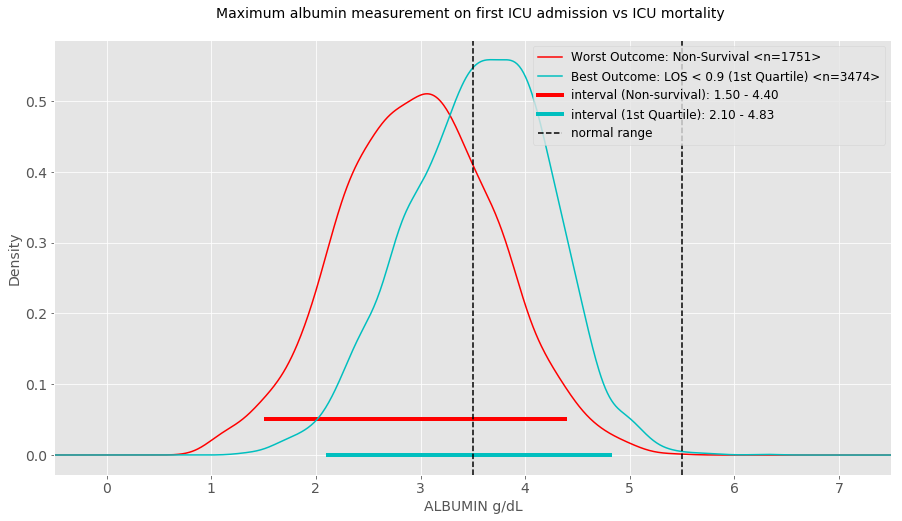

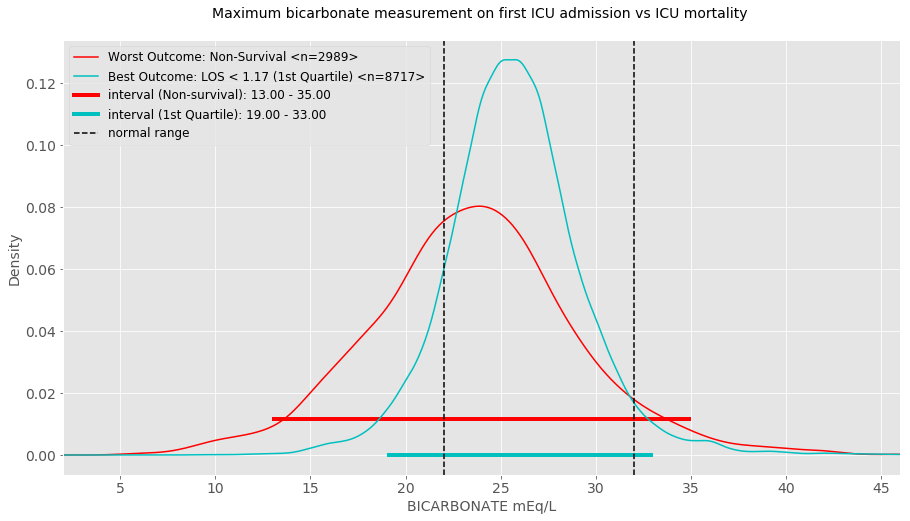

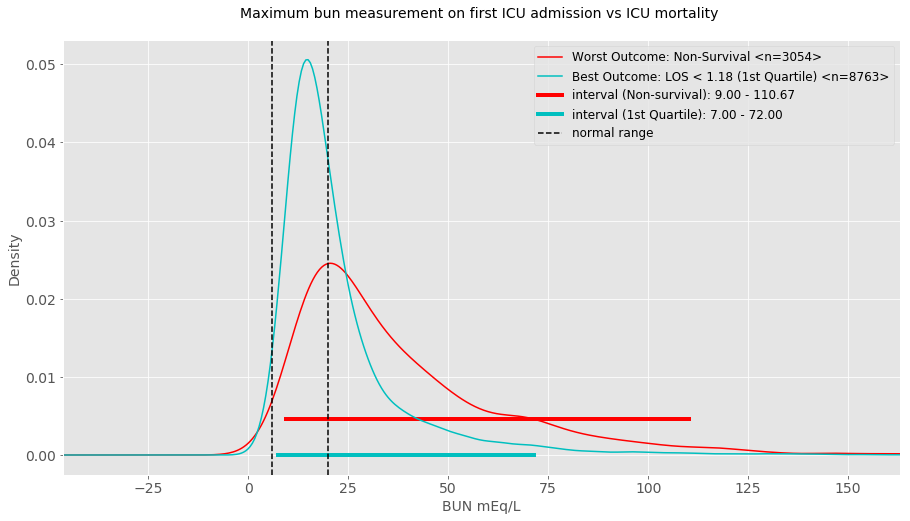

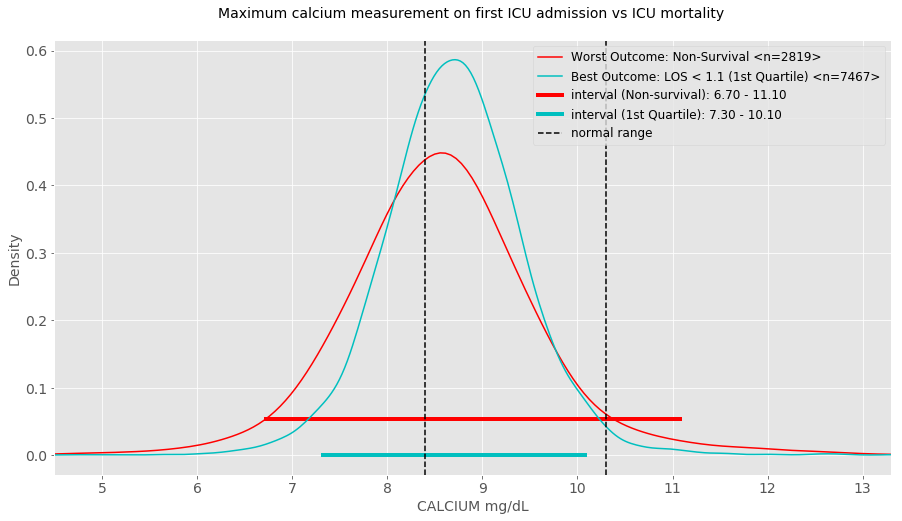

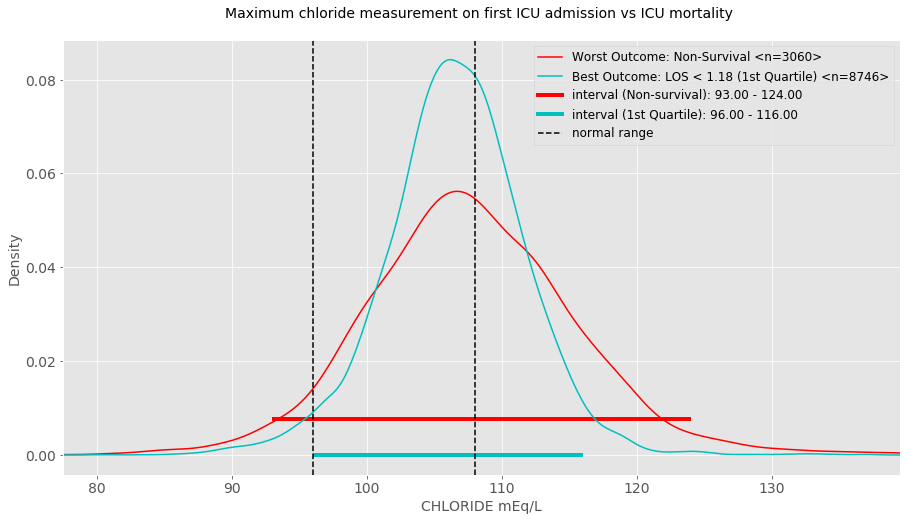

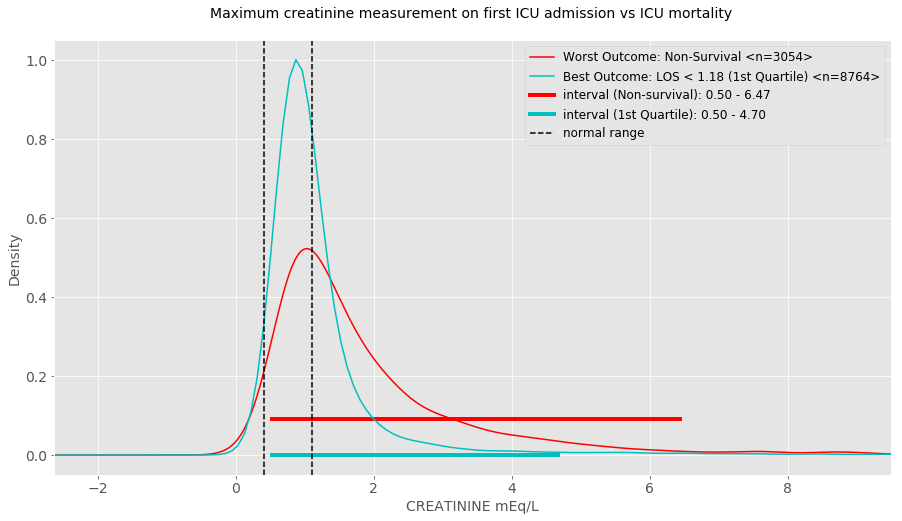

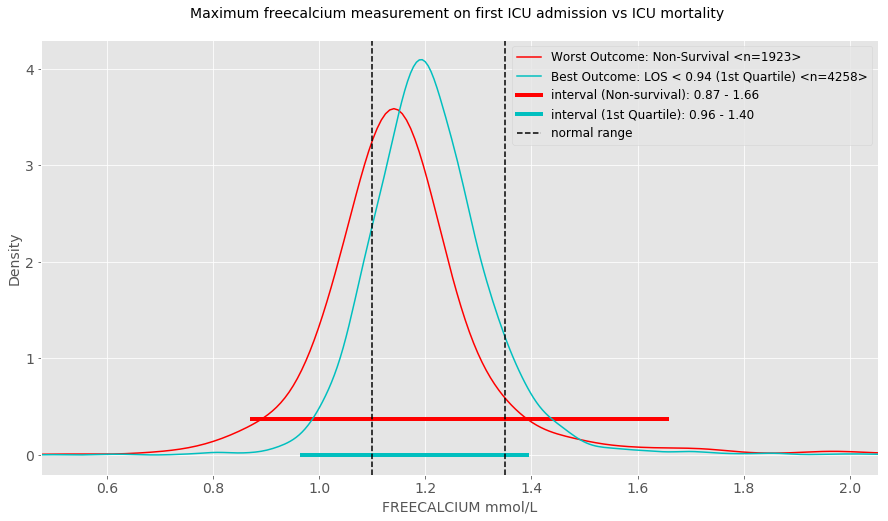

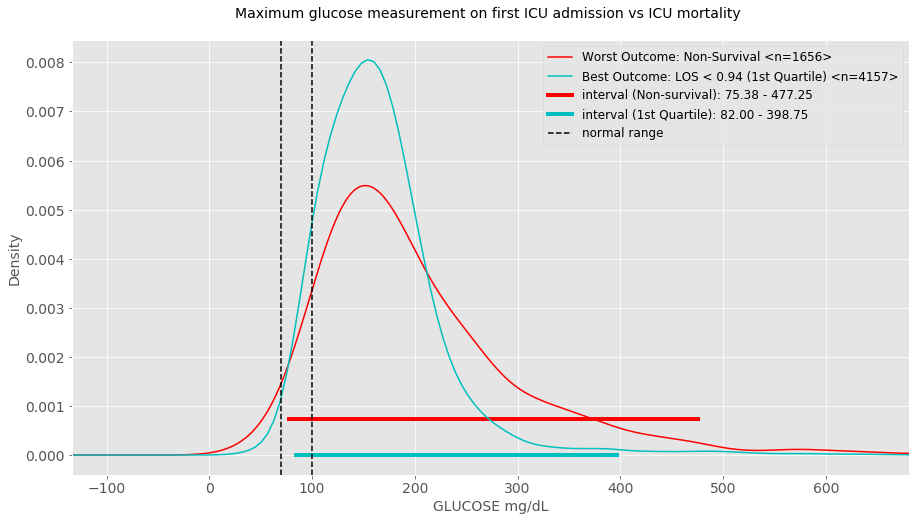

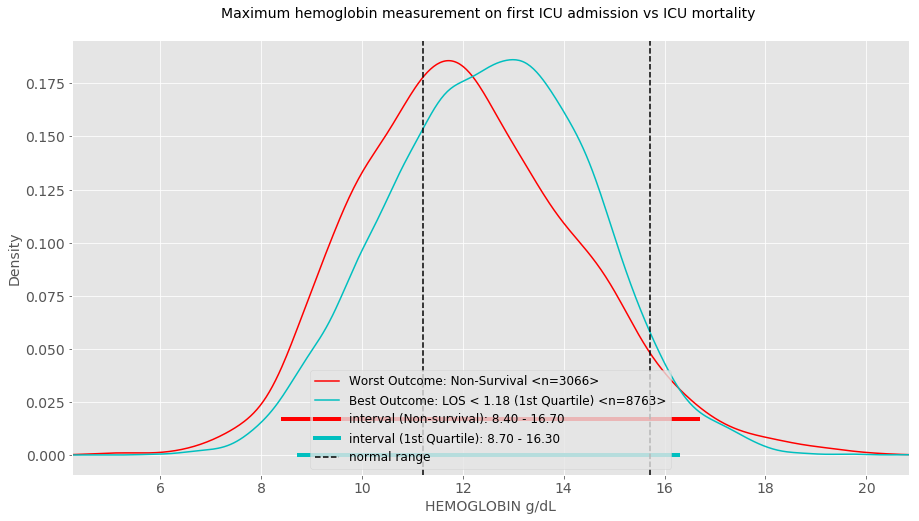

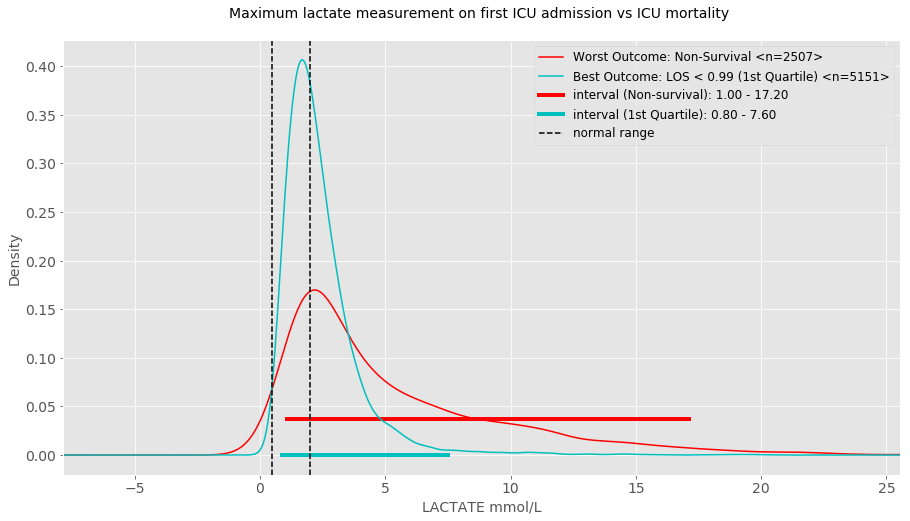

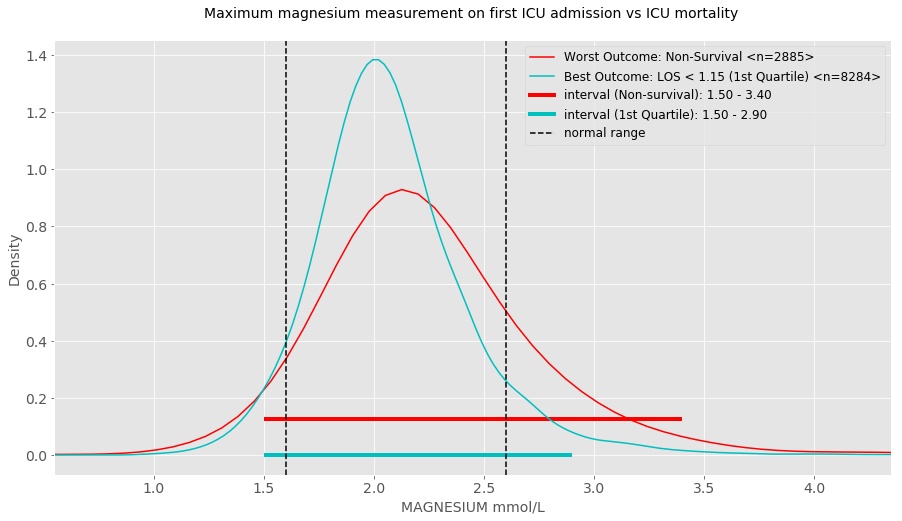

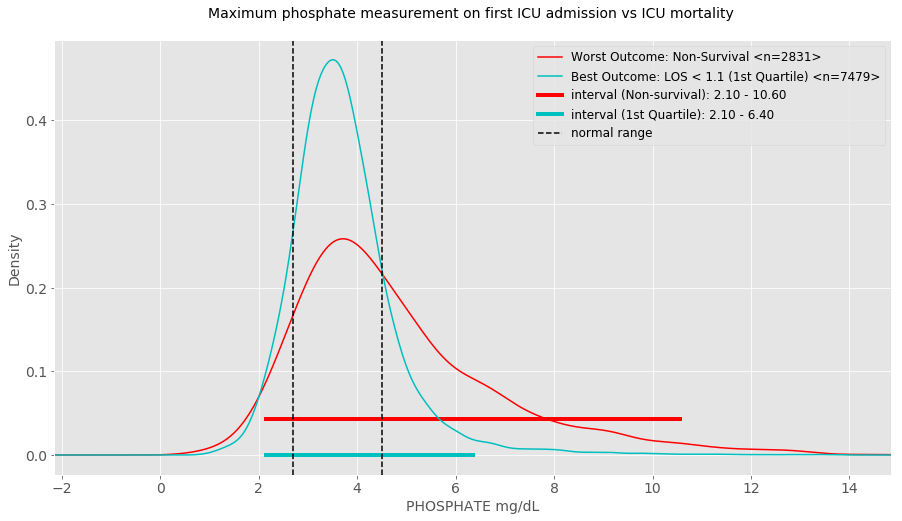

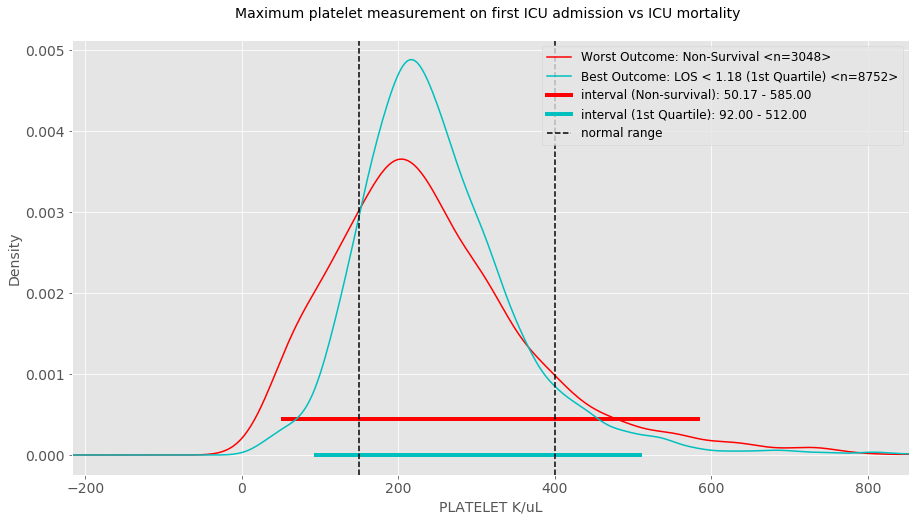

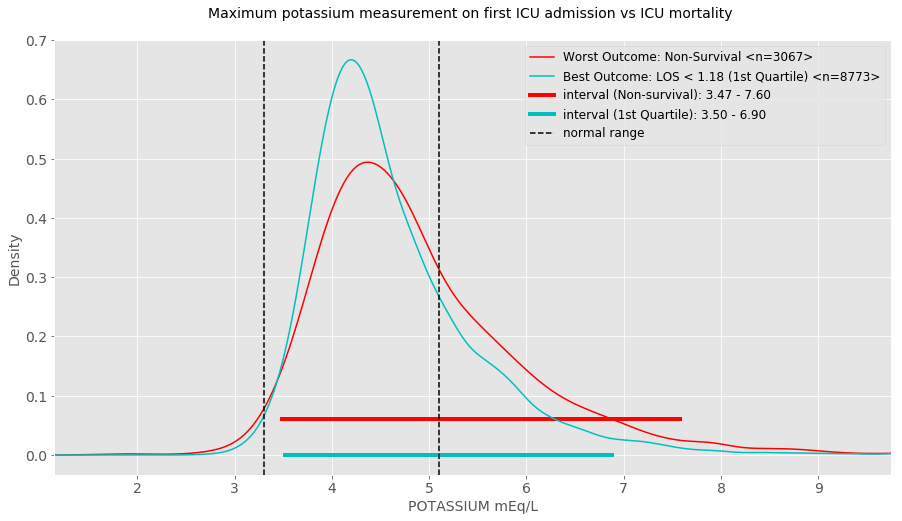

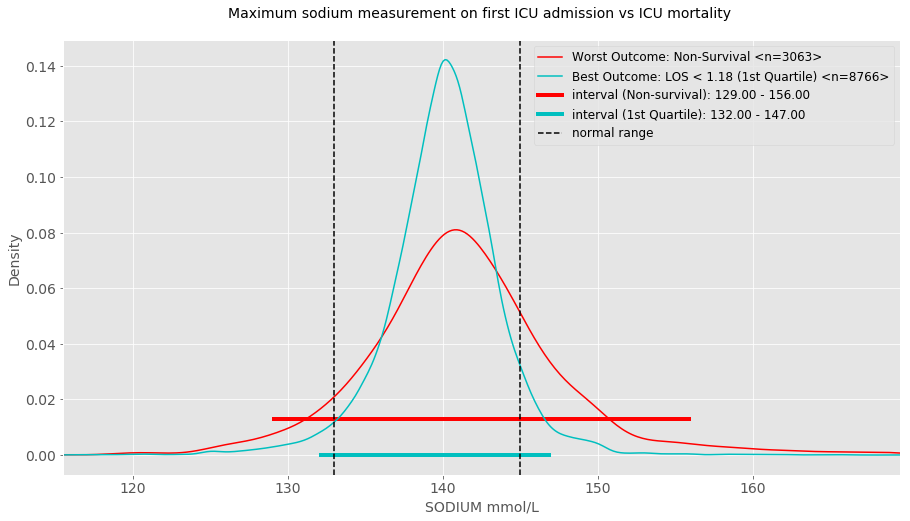

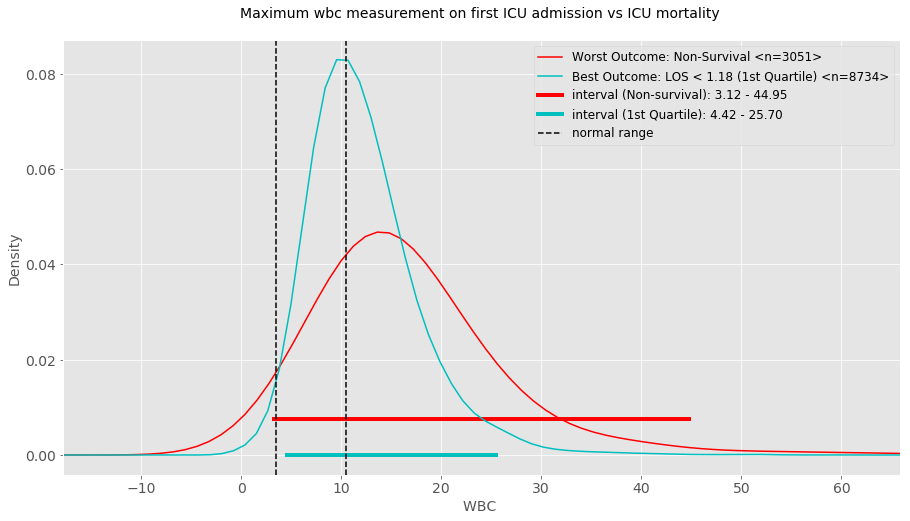

In [5]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

#cond_less = (data.mort_icu == 0) & (data.los < LOS_med)
cond_less = data.mort_icu == 0

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    
    n_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().count()
    n_less = data[l.lower()+'_max'][cond_less].dropna().count()
    quater = n_less / 4 
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().median()
    med_less = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).median()
    var_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().var()
    var_less = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).var()
    skew_nonsurv = data[l.lower()+'_max'][data.mort_icu==1].dropna().skew()
    skew_less = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).skew() 
    los_quarter = data.sort_values(by=['los'])['los'][cond_less].dropna().head(quater).max().round(2)
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_max'][data.mort_icu==1].dropna(),
                              data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater))

    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    data[l.lower()+'_max'][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Worst Outcome: Non-Survival <n={}>'.format(n_nonsurv), color='r')
    data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].dropna().head(quater).plot.kde(
        alpha=1.0,label='Best Outcome: LOS < {} (1st Quartile) <n={}>'.format(los_quarter, quater), color='c')
    
    # fake plots for KS test, median, etc
#     plt.plot([], label=' ',color='lightgray')
#     plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
#              color='lightgray')
#     plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Median (LOS < med): {}'.format(format(med_less,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Variance (LOS < med): {}'.format(format(var_less,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
#              color='lightgray')
#     plt.plot([], label='Skew (LOS < med): {}'.format(format(skew_less,'.2f')),
#              color='lightgray')

    # add 95% percentail 
    a1 = data[l.lower()+'_max'][data.mort_icu==1].quantile(0.025)
    a2 = data[l.lower()+'_max'][data.mort_icu==1].quantile(0.975)
    b1 = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].head(quater).quantile(0.025)
    b2 = data.sort_values(by=['los'])[l.lower()+'_max'][cond_less].head(quater).quantile(0.975)
    #y1 = [0.005, 0.005]
    #y2 = [0.055, 0.055]
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords
    #print a1, a2, b1, b2
    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='r')
    plt.hlines(y=0, xmin = b1, xmax = b2, linewidth=4, linestyle='-', color='c')
    #plt.plot([], label=' ', color='lightgray')
    plt.plot([], label='interval (Non-survival): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='red', linewidth=4)
    plt.plot([], label='interval (1st Quartile): {} - {}'.format(format(b1, '.2f'), format(b2, '.2f')),
                 color='c', linewidth=4)
    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    
    # add title, labels etc.
    plt.title('Maximum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    #plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.legend(fontsize=12)
    #plt.xlim(data[l.lower()+'_min'].quantile(0.00001), data[l.lower()+'_min'].quantile(0.99))
    plot_range = [min(a1, b1, lab_ranges[l][0]), max(a2, b2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    #plt.xlim(data[l.lower()+'_min'].min(axis=0), data[l.lower()+'_min'].max(axis=0))
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)

### Subgroup study:
  + GI bleeding: ICD9 , generate the same diagram on hemoglobin
  + Septic shock (sepsis) : iconized calcium and lactate
  + Initial reference codes on mimic github: https://github.com/MIT-LCP/mimic-code/blob/master/concepts/sepsis/angus.sql


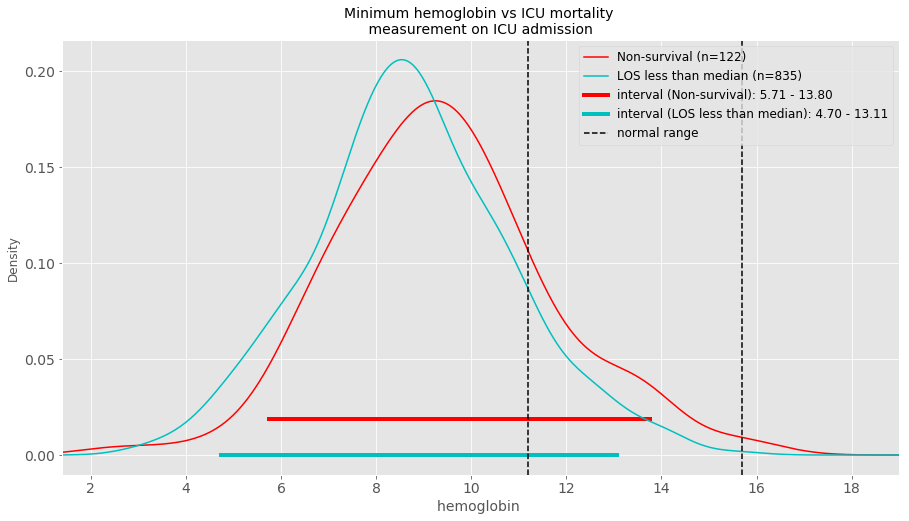

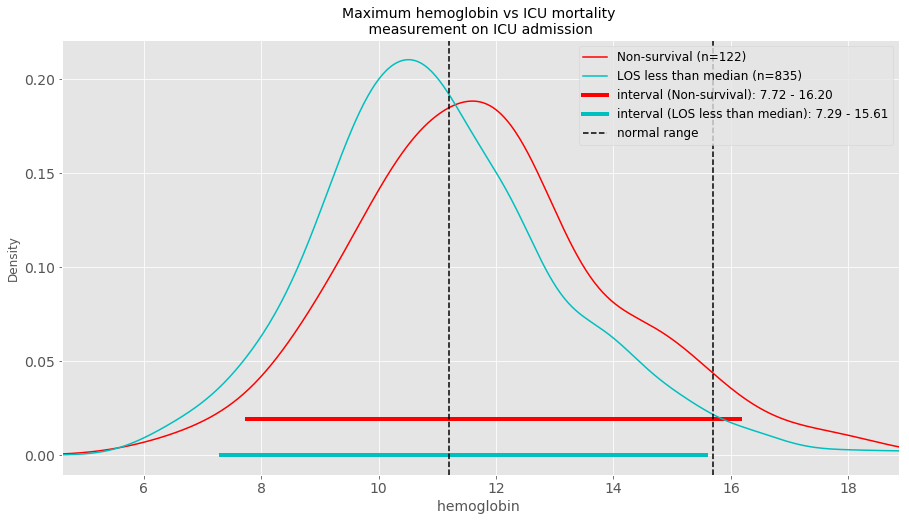

In [6]:
def drawsubgroup(datapath, subgroup, labname):
    data = pd.read_csv(datapath, index_col=0)
    data = data[data[subgroup] == 1]
    #print data.shape
    data_med = data['los'].dropna().median()
    #condi_less = (data.mort_icu==0) & (data.los < data_med)
    condi_less = data.mort_icu == 0
    for item in labname:
        n_nonsurv = data[item][data.mort_icu==1].dropna().count()
        n_less = data[item][cond_less].dropna().count()
        med_nonsurv = data[item][data.mort_icu==1].dropna().median()
        med_less = data[item][cond_less].dropna().median()
        var_nonsurv = data[item][data.mort_icu==1].dropna().var()
        var_less = data[item][cond_less].dropna().var()
        skew_nonsurv = data[item][data.mort_icu==1].dropna().skew()
        skew_less = data[item][cond_less].dropna().skew() 
        nrange = lab_ranges[item[:-4].upper()]
        # Kolmogorov Smirnov test
        ks_stat, p_val = ks_2samp(data[item][data.mort_icu==1].dropna(),
                                    data[item][cond_less].dropna())
        plt.subplots(figsize=(15,8))
        fig = plt.gcf()
        ax = plt.gca()
        data[item][data.mort_icu==1].dropna().plot.kde(
                                    alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv), color='r')
        data[item][cond_less].dropna().plot.kde(
                                    alpha=1.0,label='LOS less than median (n={})'.format(n_less), color='c')
    
    # fake plots for KS test, median, etc
#         plt.plot([], label=' ',color='lightgray')
#         plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
#                                     color='lightgray')
#         plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
#                                     color='lightgray')
#         plt.plot([], label='Median (LOS < med): {}'.format(format(med_less,'.2f')),
#                                     color='lightgray')
#         plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
#                                     color='lightgray')
#         plt.plot([], label='Variance (LOS < med): {}'.format(format(var_less,'.2f')),
#                                     color='lightgray')
#         plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
#                                     color='lightgray')
#         plt.plot([], label='Skew (LOS < med): {}'.format(format(skew_less,'.2f')),
#                                     color='lightgray')

        # add 95% percentail 
        a1 = data[item][data.mort_icu==1].quantile(0.025)
        a2 = data[item][data.mort_icu==1].quantile(0.975)
        b1 = data[item][cond_less].quantile(0.025)
        b2 = data[item][cond_less].quantile(0.975)
        #print a1, a2, b1, b2
        dy = 0.5
        i = 1  # 0 for dx
        tmp = ax.transData.transform([(0,0), (1,1)])
        tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
        tmp = 1/tmp  # 1 pixel in display coords
        tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords

        plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='r')
        plt.hlines(y=0, xmin = b1, xmax = b2, linewidth=4, linestyle='-', color='c')
        #plt.plot([], label=' ', color='lightgray')
        plt.plot([], label='interval (Non-survival): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                                    color='red', linewidth=4)
        plt.plot([], label='interval (LOS less than median): {} - {}'.format(format(b1, '.2f'), format(b2, '.2f')),
                                    color='c', linewidth=4)
        plt.axvline(nrange[0],color='k',linestyle='--', label="normal range")
        plt.axvline(nrange[1],color='k',linestyle='--')
        # add title, labels etc.
        plt.title('{} {} measurement on ICU admission '.format(item[-3].upper()+item[-2:]+"imum", item[:-4] +
                                    ' vs ICU mortality \n'), fontsize=14)
        plt.xlabel(item[:-4] + ' ' + u, fontsize=14)
        #plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
        plt.legend(fontsize=12)
        plot_range = [min(a1, b1, nrange[0]), max(a2, b2, nrange[1])]
        diff = plot_range[1] - plot_range[0]
        #plt.xlim(data[l.lower()+'_min'].min(axis=0), data[l.lower()+'_min'].max(axis=0))
        plt.xlim(plot_range[0] - 0.3 * diff, plot_range[1] + 0.3 * diff)
    
        # Add lab range if available
        
        plt.tick_params(axis='both', labelsize=14)

drawsubgroup('subgroup_data_minmax.csv', 'gi_bleeding', ['hemoglobin_min', 'hemoglobin_max'])

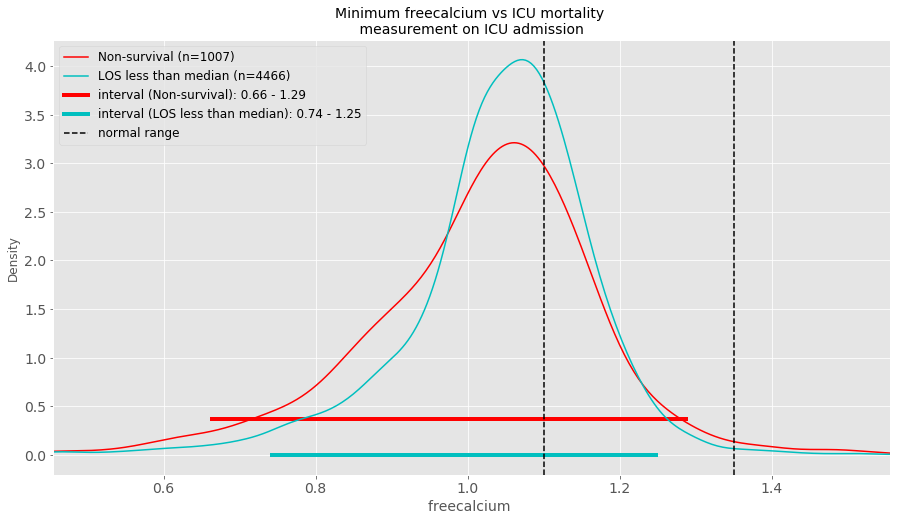

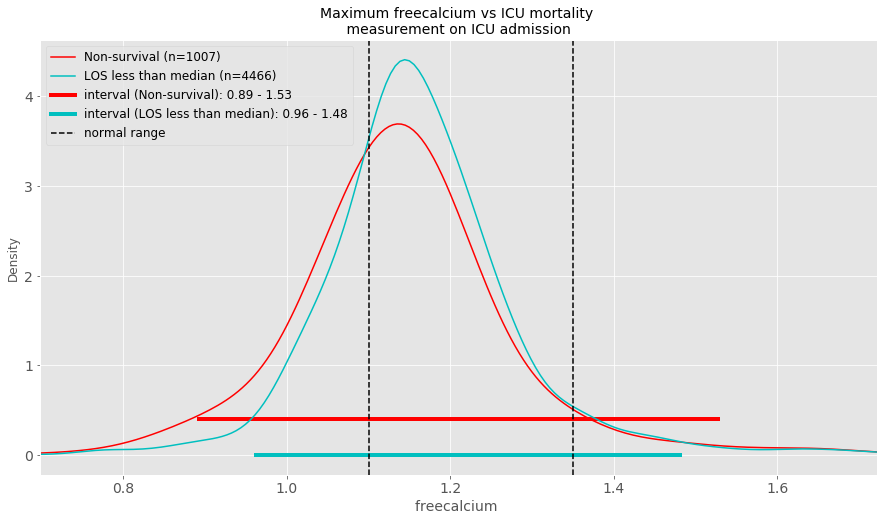

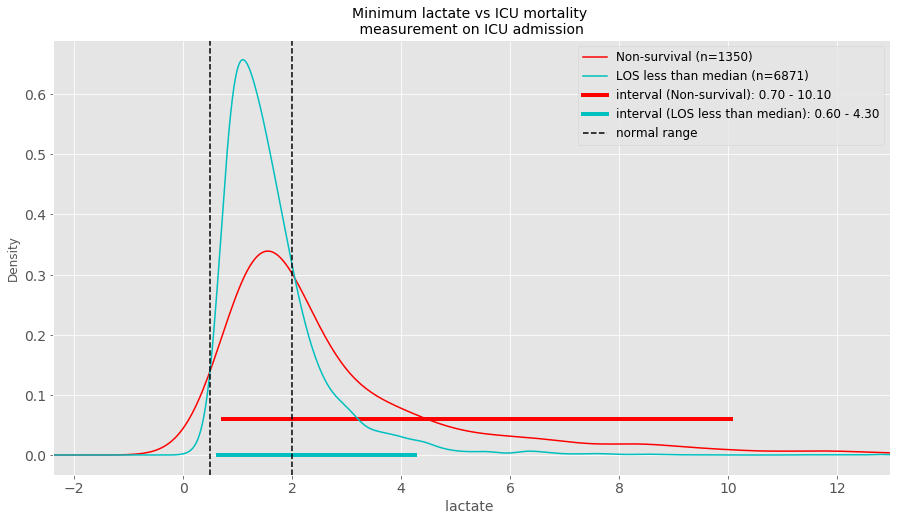

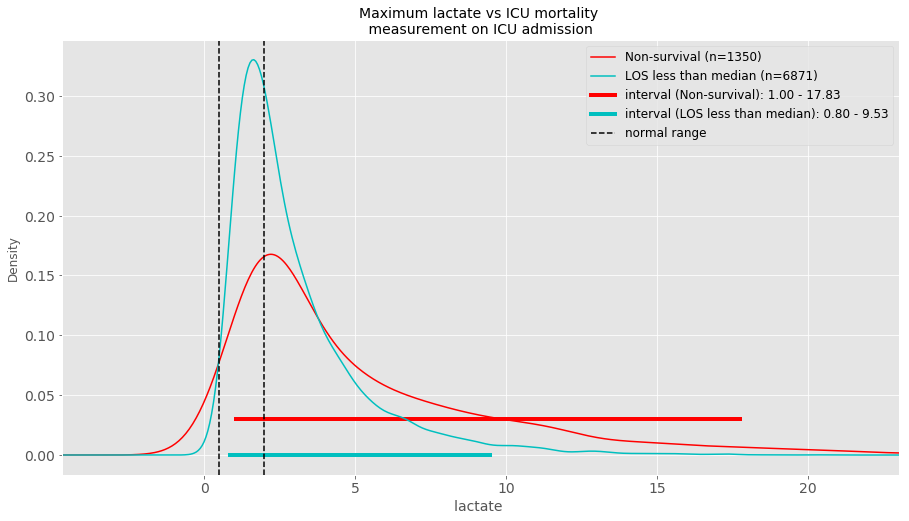

In [7]:
drawsubgroup('subgroup_data_minmax.csv', 'angus', ['freecalcium_min', 'freecalcium_max', 'lactate_min','lactate_max'])